In [1]:
from utils import load_imagedataset
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms

In [2]:
# def plot_batch_imgs(imgs):
#     fig, ax = plt.subplots(1,8, figsize=(50, 50))
#     for i, img in enumerate(imgs):
#         if img.shape[0] == 1:
#             ax[i].imshow(img.permute(1,2,0), cmap="gray")
#         else:
#             ax[i].imshow(img.permute(1,2,0))
#     fig.show()

def plot_slc_imgs(imgs, labels, mu, sigma):
    # x_i, xhat_j, x_j = imgs
    num_imgs = imgs[0].shape[0]
    batch_len = len(imgs)
    fig, ax = plt.subplots(batch_len, num_imgs, figsize=(20, 20))
    for k in range(batch_len):
        for l, img in enumerate(imgs[k]):
            img = img * torch.tensor(sigma)[:, None, None] + torch.tensor(mu)[:, None, None]
            if img.shape[0] == 1:
                ax[k, l].imshow(img.permute(1,2,0), cmap="gray")
            else:
                ax[k, l].imshow(img.permute(1,2,0))
            if labels is not None:
                ax[k,l].set_title(labels[k][l].item())
    #fig.subplots_adjust(hspace=-0.5, vspace=-2)
    fig.subplots_adjust(hspace=-0.9)
    fig.tight_layout()
    fig.show()


In [3]:
class SCLDataset(Dataset):
    def __init__(self, basedataset, train_transform, eval_transform):
        self.basedataset = basedataset
        self.train_transform = train_transform
        self.eval_transform = eval_transform

    def __getitem__(self, item):
        x_i_orig, y_i = self.basedataset[item]  # uniform [1,...,N]
        x_i = self.train_transform(x_i_orig)
        xhat_i = self.train_transform(x_i_orig)
        j = torch.randint(low=0, high=len(self.basedataset), size=(1,)).item()
        x_j_orig, y_j = self.basedataset[j]  # uniform [1,...,N]^2
        x_j = self.train_transform(x_j_orig)
        return x_i, xhat_i, x_j, y_i, y_j, self.eval_transform(x_i_orig), self.eval_transform(x_j_orig)

    def __len__(self):
        return len(self.basedataset)

In [4]:
class SCLTrainTransform():
    # augmentations as described in SimCLR paper
    def __init__(self, imgsize, mean, std, s=0.5, gaus_blur=False, num_views=2, p_flip=0.5):
        self.num_views = num_views
        color_jitter = transforms.ColorJitter(
            brightness=0.8*s,
            contrast=0.8*s,
            saturation=0.8*s,
            hue=0.2*s
        )
        transform = [
            transforms.RandomResizedCrop(size=imgsize),  #, scale=(0.14, 1)),
            transforms.RandomHorizontalFlip(p=p_flip),
            transforms.RandomApply([color_jitter], p=0.8),
            transforms.RandomGrayscale(p=0.2)
        ]
        if gaus_blur:
            transform.append(transforms.GaussianBlur(kernel_size=int(imgsize*0.1), sigma=(0.1, 2.0)))
        transform.append(transforms.ToTensor())
        transform.append(transforms.Normalize(mean, std))
        self.transform = transforms.Compose(transform)

    def __call__(self, x):
        return [self.transform(x) for _ in range(self.num_views)] if self.num_views > 1 else self.transform(x)


class SCLMnistTrainTransform():
    def __init__(self, imgsize, mean, std, s=0.5, gaus_blur=False, num_views=2, p_flip=0.0):
        self.num_views = num_views
        color_jitter = transforms.ColorJitter(
            brightness=0.8*s,
            contrast=0.8*s,
            saturation=0.8*s,
            hue=0.2*s
        )
        
        transform = [
            #transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.8, 1.1)),
            transforms.Resize(size=imgsize),  #, scale=(0.14, 1)),
            #transforms.CenterCrop(size=imgsize),  #, scale=(0.14, 1)),
            transforms.RandomHorizontalFlip(p=p_flip),
            transforms.RandomApply([color_jitter], p=0.8),
            transforms.RandomGrayscale(p=0.2),
        ]
        if gaus_blur:
            transform.append(transforms.GaussianBlur(kernel_size=int(imgsize*0.1), sigma=(0.1, 2.0)))
        transform.append(transforms.ToTensor())
        transform.append(transforms.Normalize(mean, std))
        self.transform = transforms.Compose(transform)

    def __call__(self, x):
        return [self.transform(x) for _ in range(self.num_views)] if self.num_views > 1 else self.transform(x)


class SCLEvalTransform():
    def __init__(self, mean, std, imgsize, num_views=2):
        self.num_views = num_views
        transform = [
            transforms.Resize(imgsize),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]
        self.transform = transforms.Compose(transform)

    def __call__(self, x):
        return [self.transform(x) for _ in range(self.num_views)] if self.num_views > 1 else self.transform(x)


# CIFAR-10

In [5]:
datasetname = "cifar10"
traindataset, valdataset, testdataset, mean, std, num_classes = load_imagedataset(datasetname, val_split=0.1)

imgsize = 32
s = 0.5
gaus_blur = True
num_views = 1
p_flip = 0.5

dataloader = DataLoader(
    dataset=SCLDataset(
        traindataset, 
        train_transform=SCLTrainTransform(
            imgsize=imgsize,
            mean=mean,
            std=std,
            s=s,
            gaus_blur=gaus_blur,
            num_views=num_views,
            p_flip=p_flip
        ),
        eval_transform=SCLEvalTransform(
            imgsize=imgsize,
            mean=mean,
            std=std,
            num_views=num_views,
        )
    ), 
    batch_size=8, 
    shuffle=False
)

x_i, xhat_i, x_j, y_i, y_j, x_i_orig, x_j_orig = next(iter(dataloader))

Files already downloaded and verified
Files already downloaded and verified


/tmp/ipykernel_89844/482099675.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


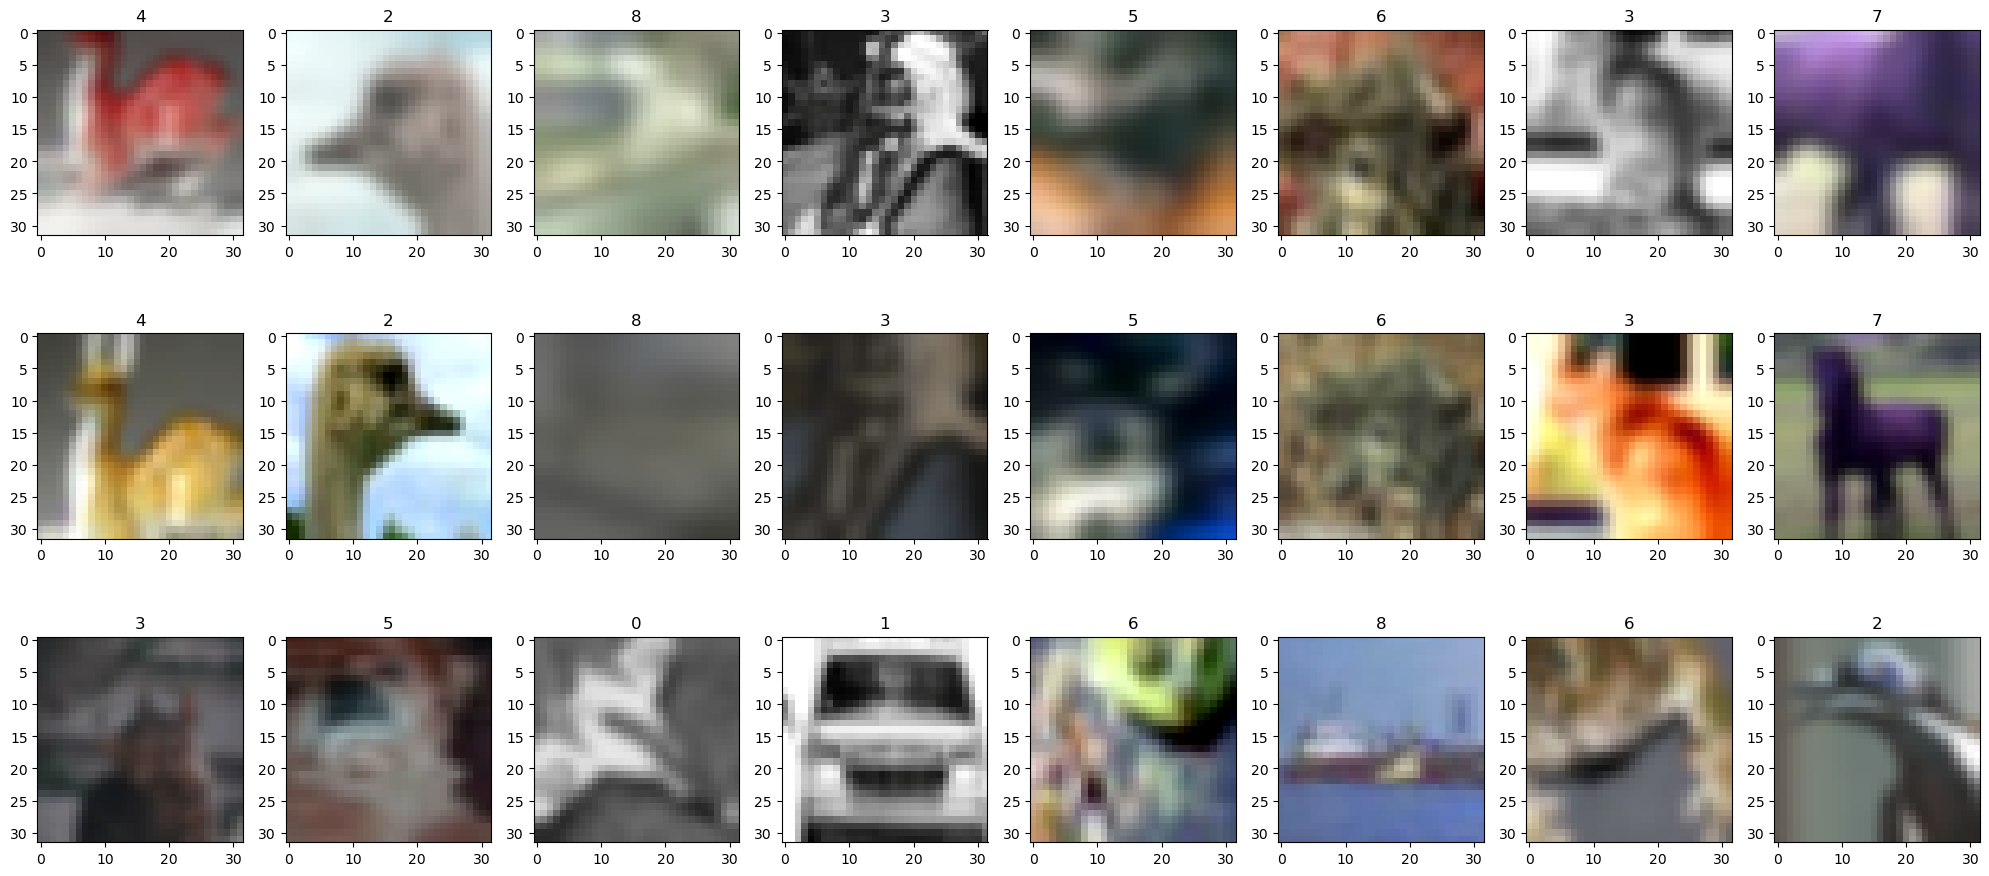

In [6]:
aug_imgs = x_i, xhat_i, x_j
labels = [y_i, y_i, y_j]
plot_slc_imgs(aug_imgs, labels, mean, std)

/tmp/ipykernel_89844/482099675.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


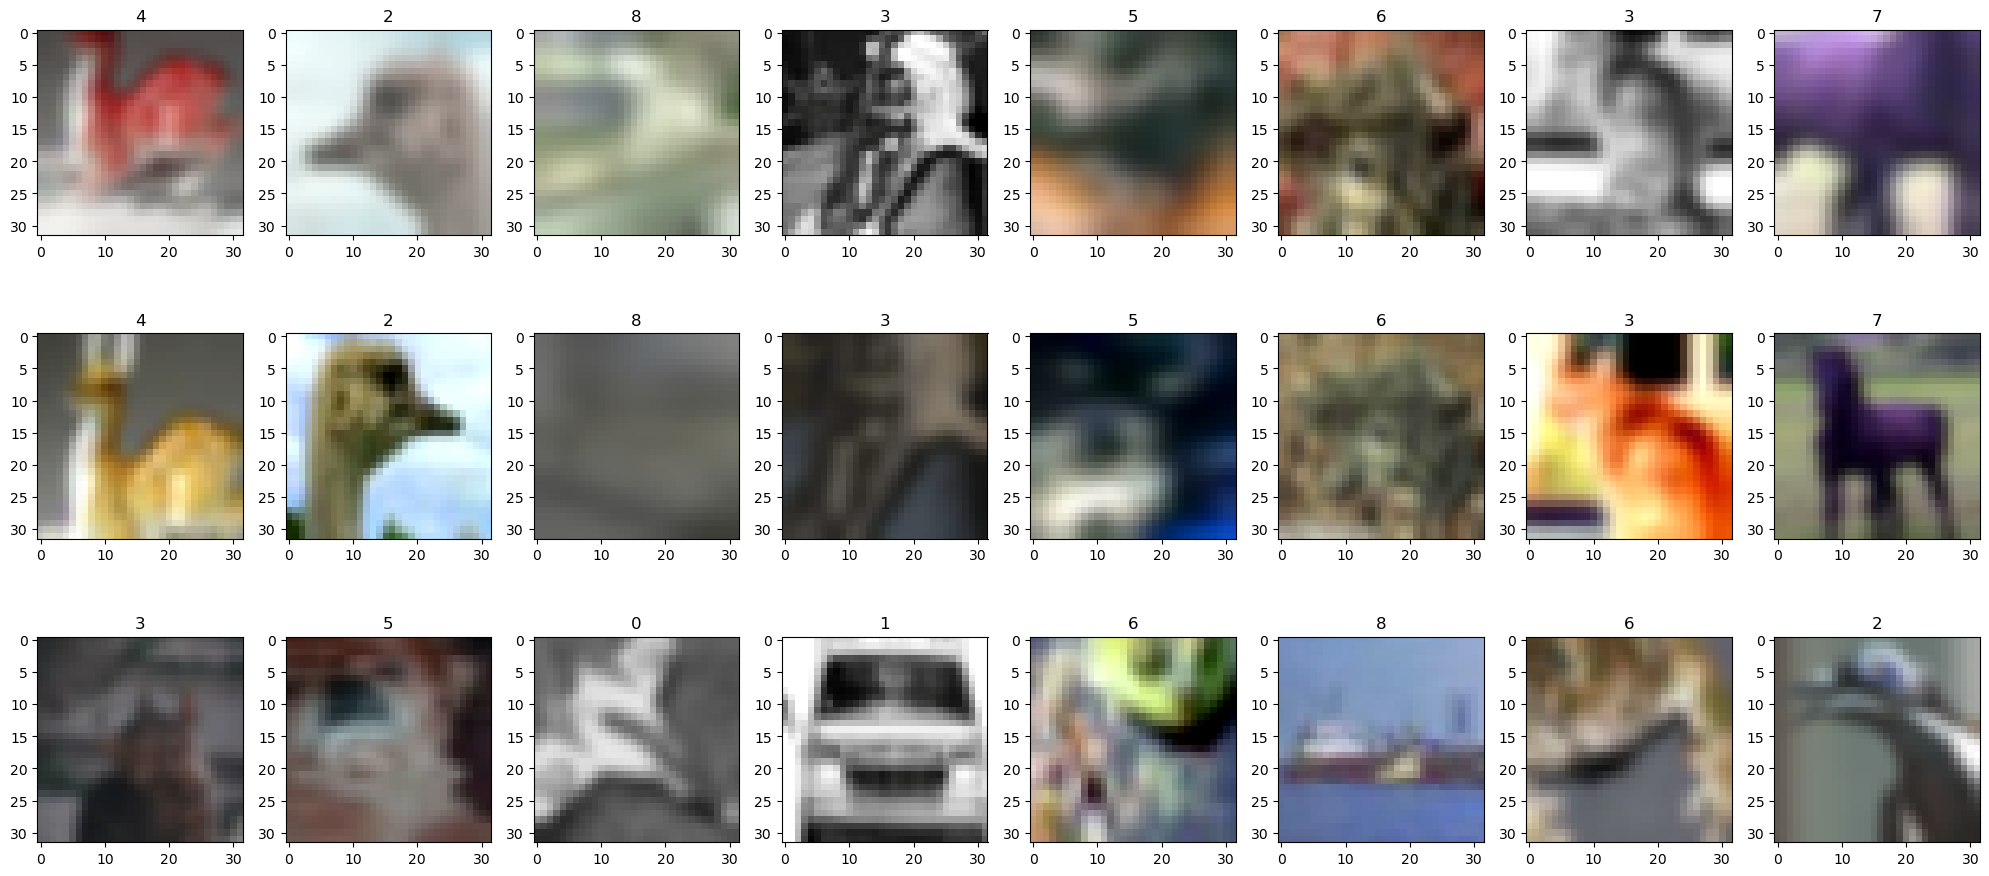

In [7]:
aug_imgs = x_i, xhat_i, x_j
labels = [y_i, y_i, y_j]
plot_slc_imgs(aug_imgs, labels, mean, std)

/tmp/ipykernel_89844/482099675.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


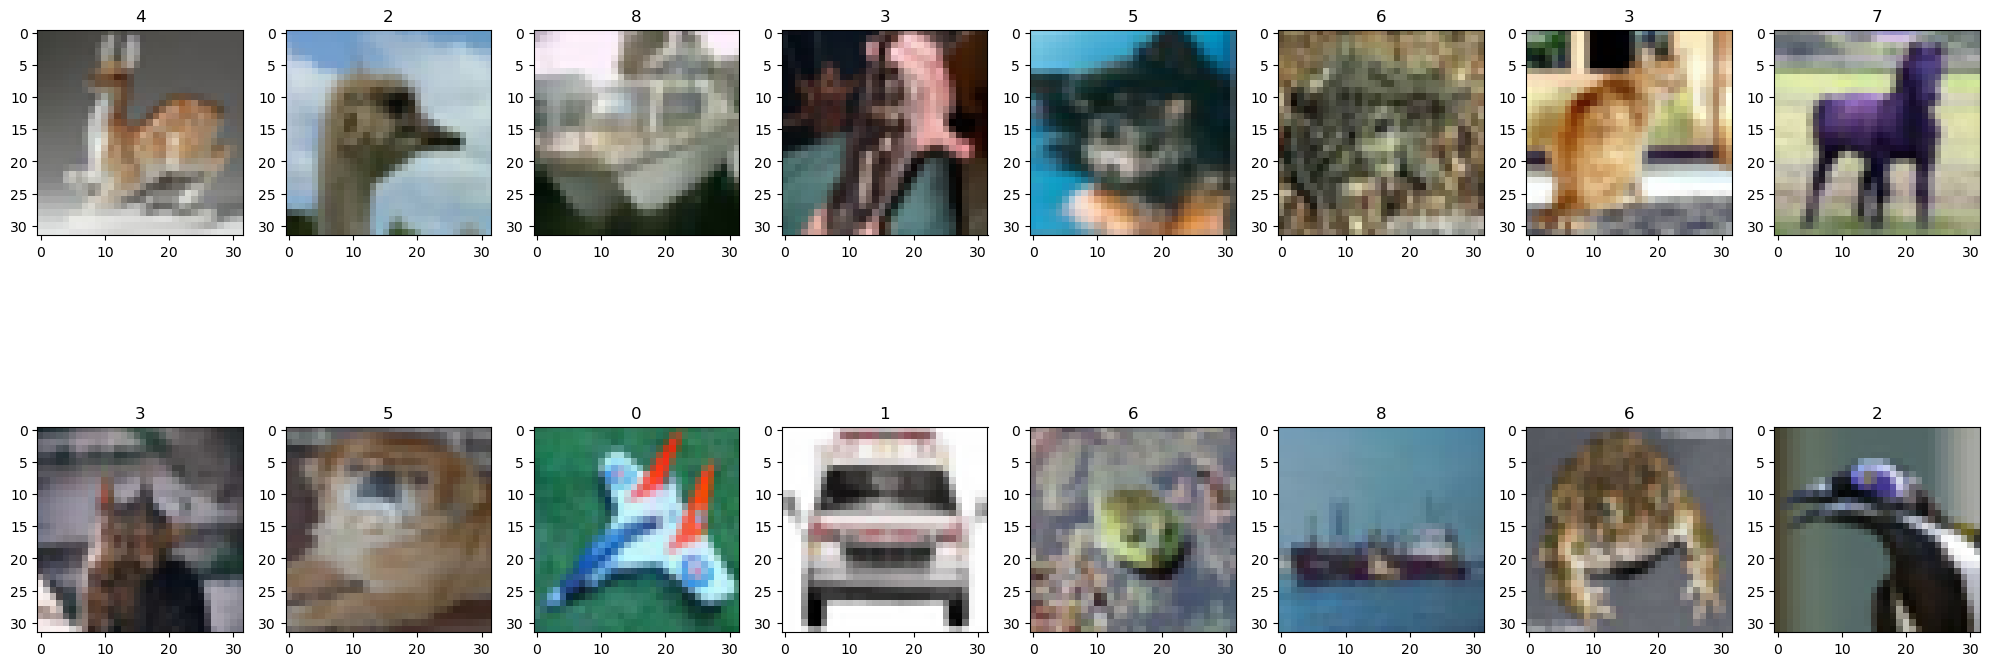

In [8]:
orig_imgs = x_i_orig, x_j_orig
labels = [y_i, y_j]
plot_slc_imgs(orig_imgs, labels, mean, std)

# MNIST

In [9]:
datasetname = "mnist"
traindataset, valdataset, testdataset, mean, std, num_classes = load_imagedataset(datasetname, val_split=0.1)

imgsize = 32
s = 0.5
gaus_blur = True
num_views = 1
p_flip = 0.0

dataloader = DataLoader(
    dataset=SCLDataset(
        traindataset,
        train_transform=SCLMnistTrainTransform(
            imgsize=imgsize,
            mean=mean,
            std=std,
            s=s,
            gaus_blur=gaus_blur,
            num_views=num_views,
            p_flip=p_flip
        ),
        eval_transform=SCLEvalTransform(
            imgsize=imgsize,
            mean=mean,
            std=std,
            num_views=num_views,
        )
    ),
    batch_size=8,
    shuffle=False
)

x_i, xhat_i, x_j, y_i, y_j, x_i_orig, x_j_orig = next(iter(dataloader))

/tmp/ipykernel_89844/482099675.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


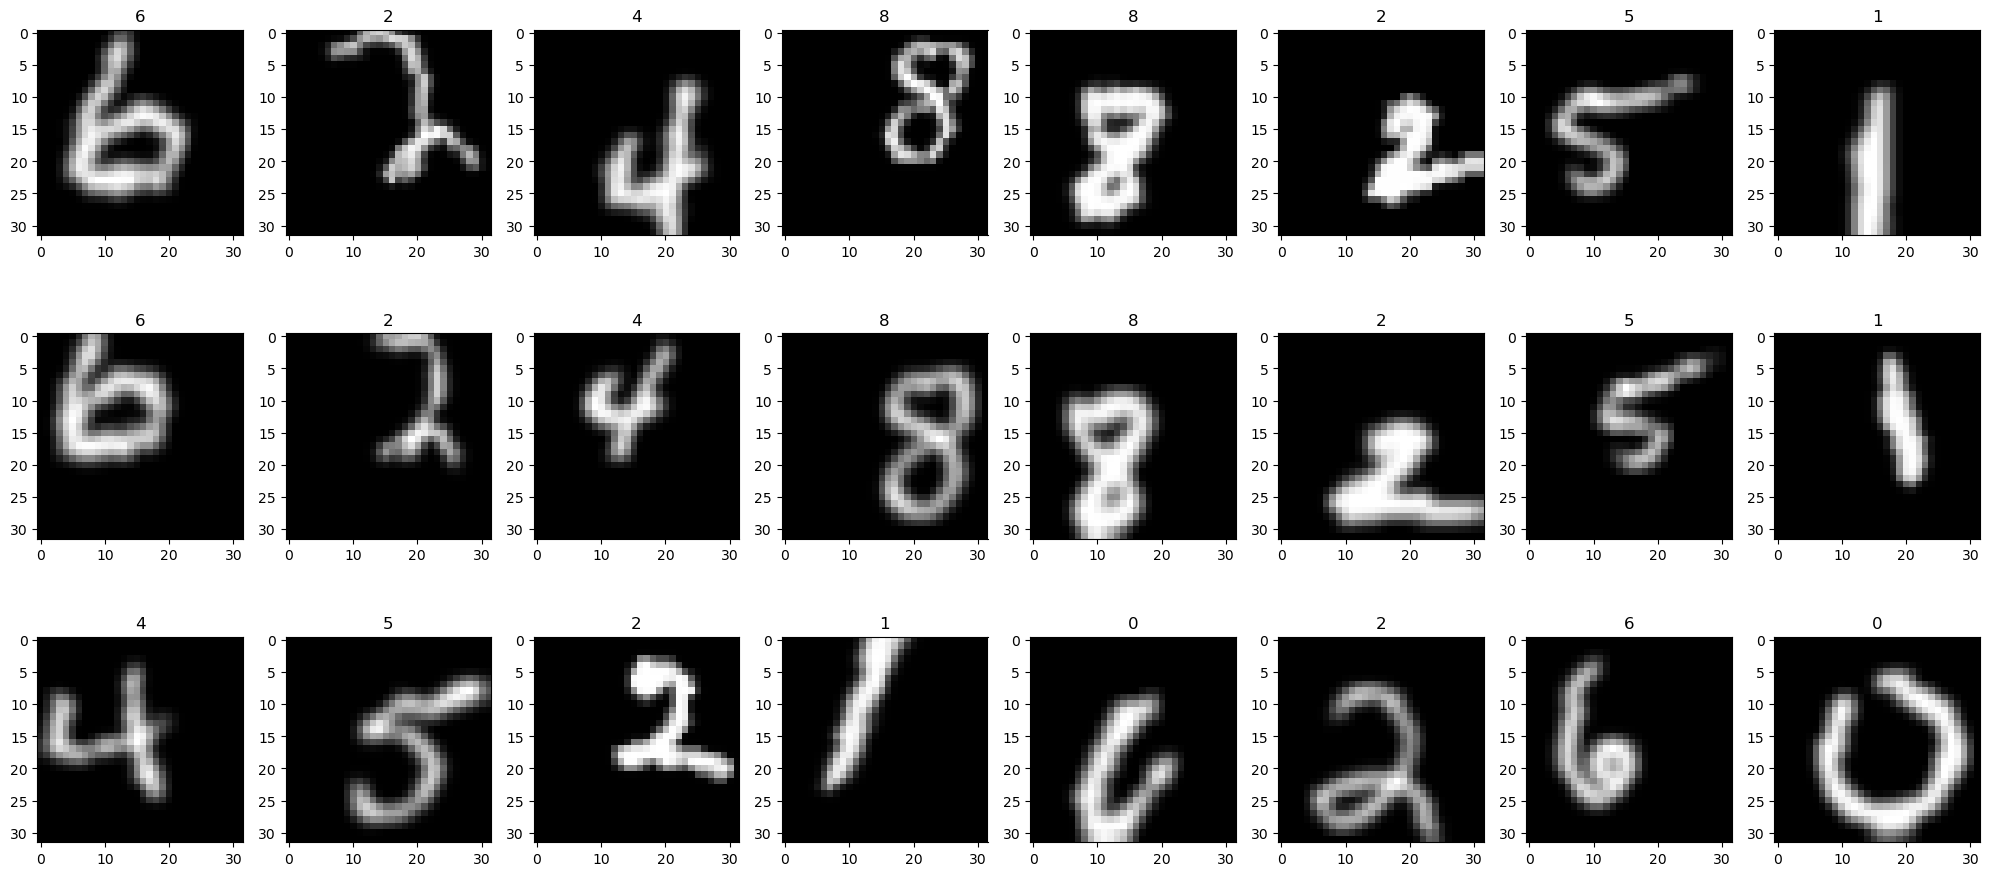

In [10]:
aug_imgs = x_i, xhat_i, x_j
labels = [y_i, y_i, y_j]
plot_slc_imgs(aug_imgs, labels, mean, std)

/tmp/ipykernel_89844/482099675.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


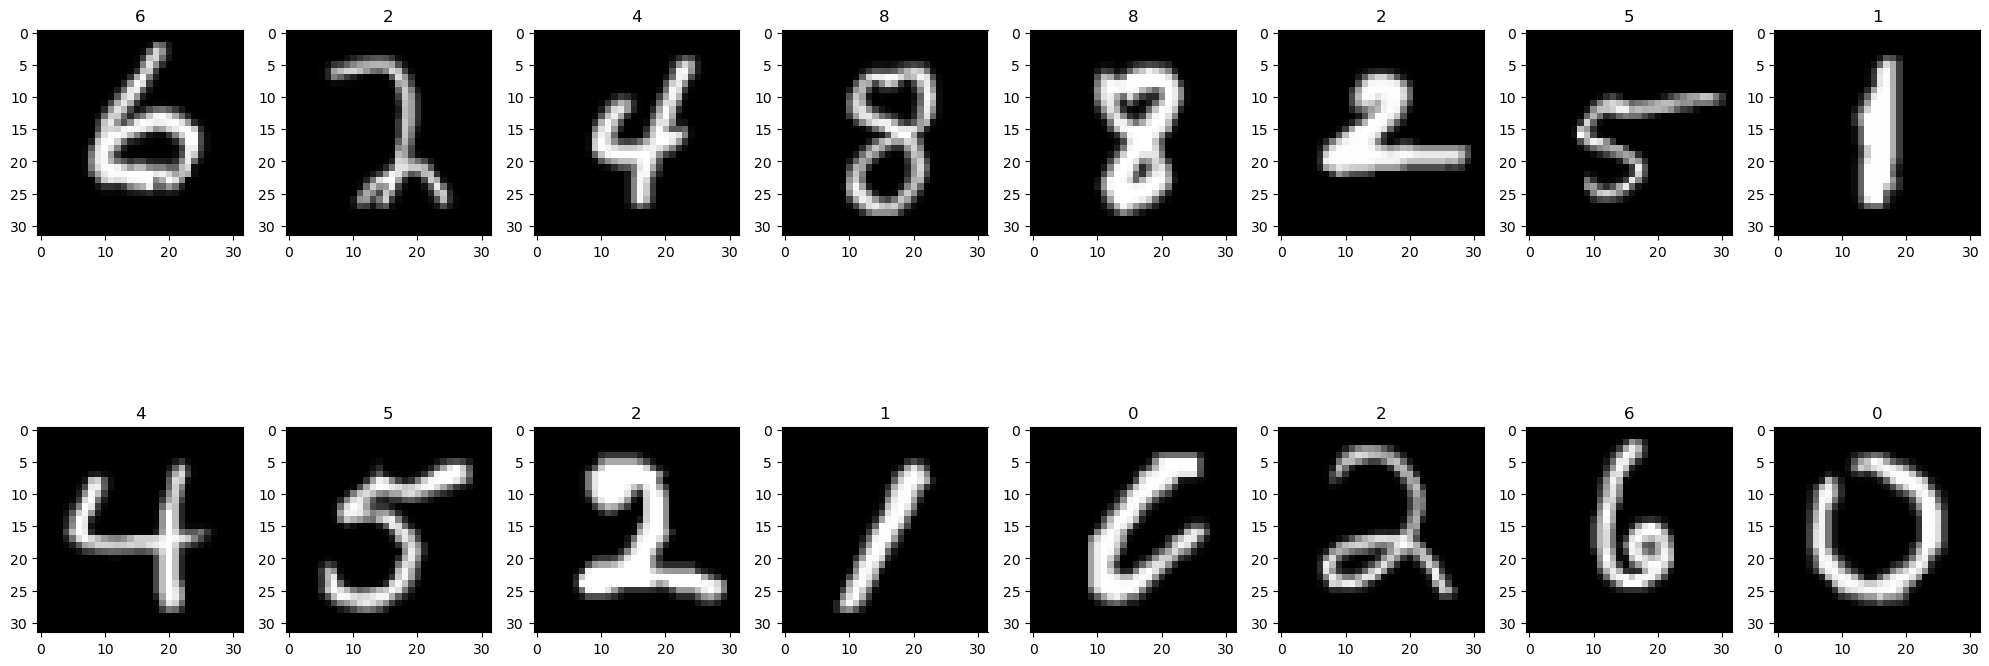

In [11]:
orig_imgs = x_i_orig, x_j_orig
labels = [y_i, y_j]
plot_slc_imgs(orig_imgs, labels, mean, std)

In [12]:
datasetname = "fashionmnist"
traindataset, valdataset, testdataset, mean, std, num_classes = load_imagedataset(datasetname, val_split=0.1)

imgsize = 32
s = 0.5
gaus_blur = True
num_views = 1
p_flip = 0.5

dataloader = DataLoader(
    dataset=SCLDataset(
        traindataset,
        train_transform=SCLMnistTrainTransform(
            imgsize=imgsize,
            mean=mean,
            std=std,
            s=s,
            gaus_blur=gaus_blur,
            num_views=num_views,
            p_flip=p_flip
        ),
        eval_transform=SCLEvalTransform(
            imgsize=imgsize,
            mean=mean,
            std=std,
            num_views=num_views,
        )
    ),
    batch_size=8,
    shuffle=False
)

x_i, xhat_i, x_j, y_i, y_j, x_i_orig, x_j_orig = next(iter(dataloader))

/tmp/ipykernel_89844/482099675.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


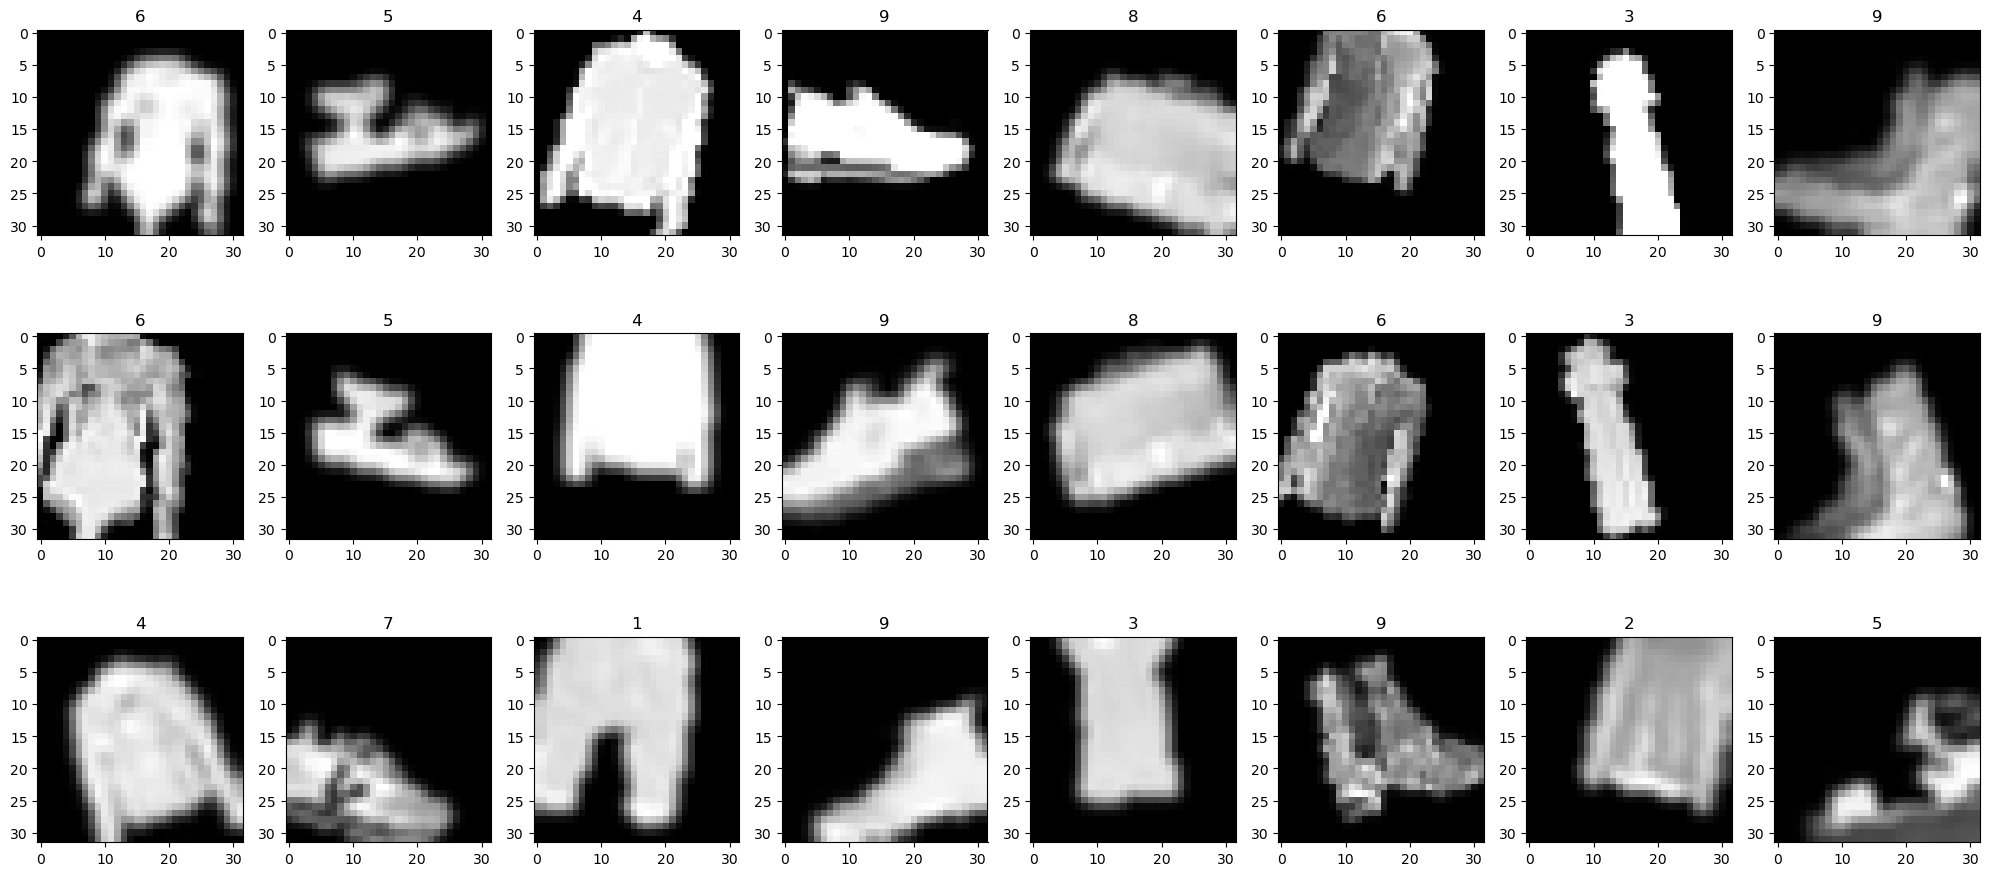

In [13]:
aug_imgs = x_i, xhat_i, x_j
labels = [y_i, y_i, y_j]
plot_slc_imgs(aug_imgs, labels, mean, std)

/tmp/ipykernel_89844/482099675.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


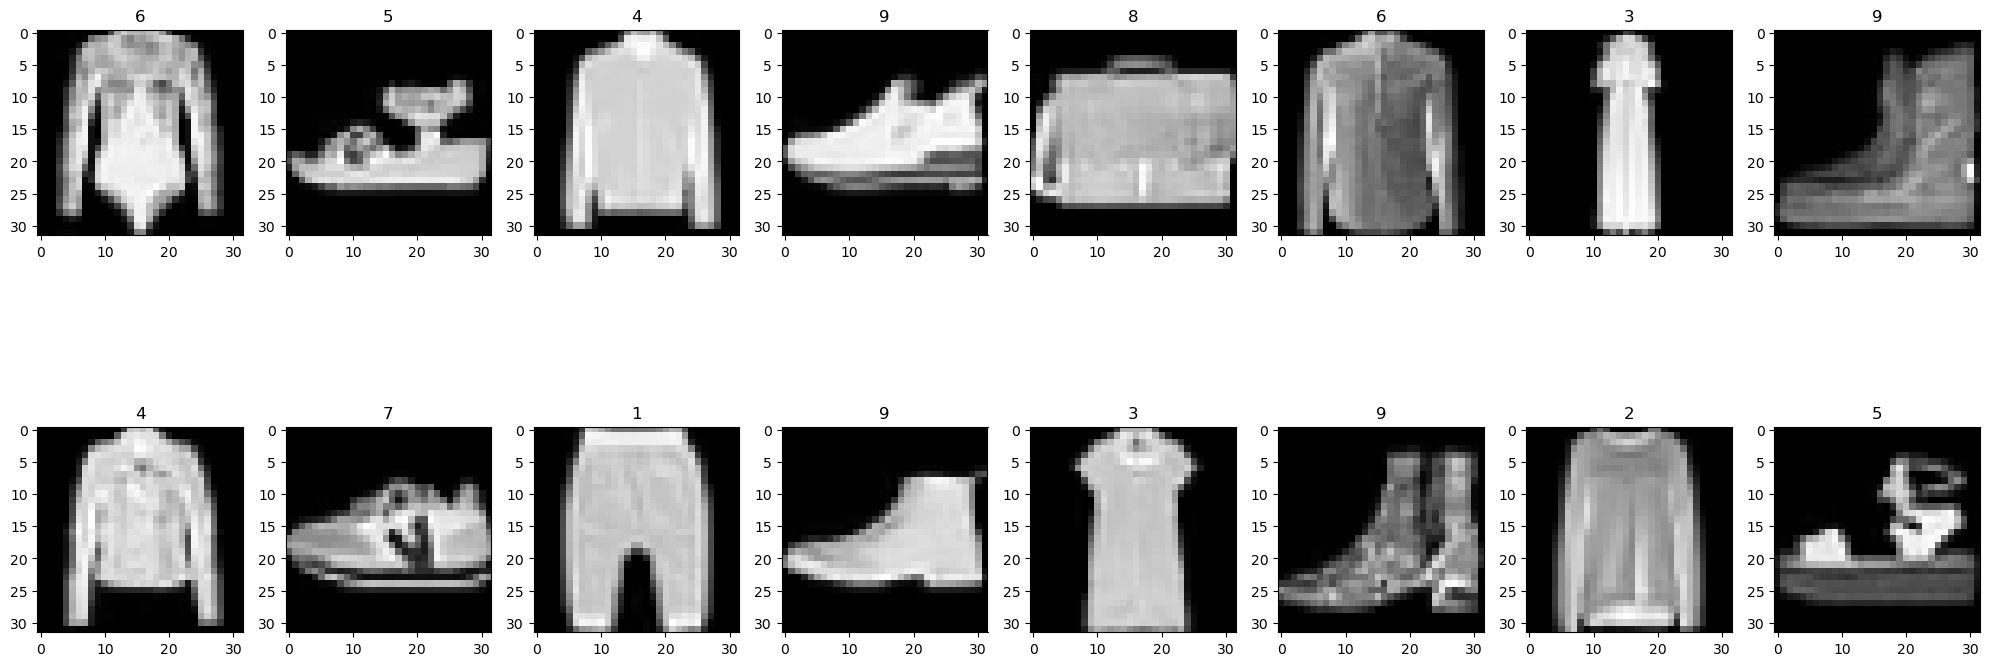

In [14]:
orig_imgs = x_i_orig, x_j_orig
labels = [y_i, y_j]
plot_slc_imgs(orig_imgs, labels, mean, std)

In [15]:
datasetname = "svhn"
traindataset, valdataset, testdataset, mean, std, num_classes = load_imagedataset(datasetname, val_split=0.1)

imgsize = 32
s = 0.5
gaus_blur = True
num_views = 1
p_flip = 0.0

dataloader = DataLoader(
    dataset=SCLDataset(
        traindataset,
        train_transform=SCLMnistTrainTransform(
            imgsize=imgsize,
            mean=mean,
            std=std,
            s=s,
            gaus_blur=gaus_blur,
            num_views=num_views,
            p_flip=p_flip
        ),
        eval_transform=SCLEvalTransform(
            imgsize=imgsize,
            mean=mean,
            std=std,
            num_views=num_views,
        )
    ),
    batch_size=8,
    shuffle=False
)

x_i, xhat_i, x_j, y_i, y_j, x_i_orig, x_j_orig = next(iter(dataloader))

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/train_32x32.mat


In [16]:
y_i

tensor([8, 1, 1, 1, 3, 5, 0, 1])

/tmp/ipykernel_89844/482099675.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


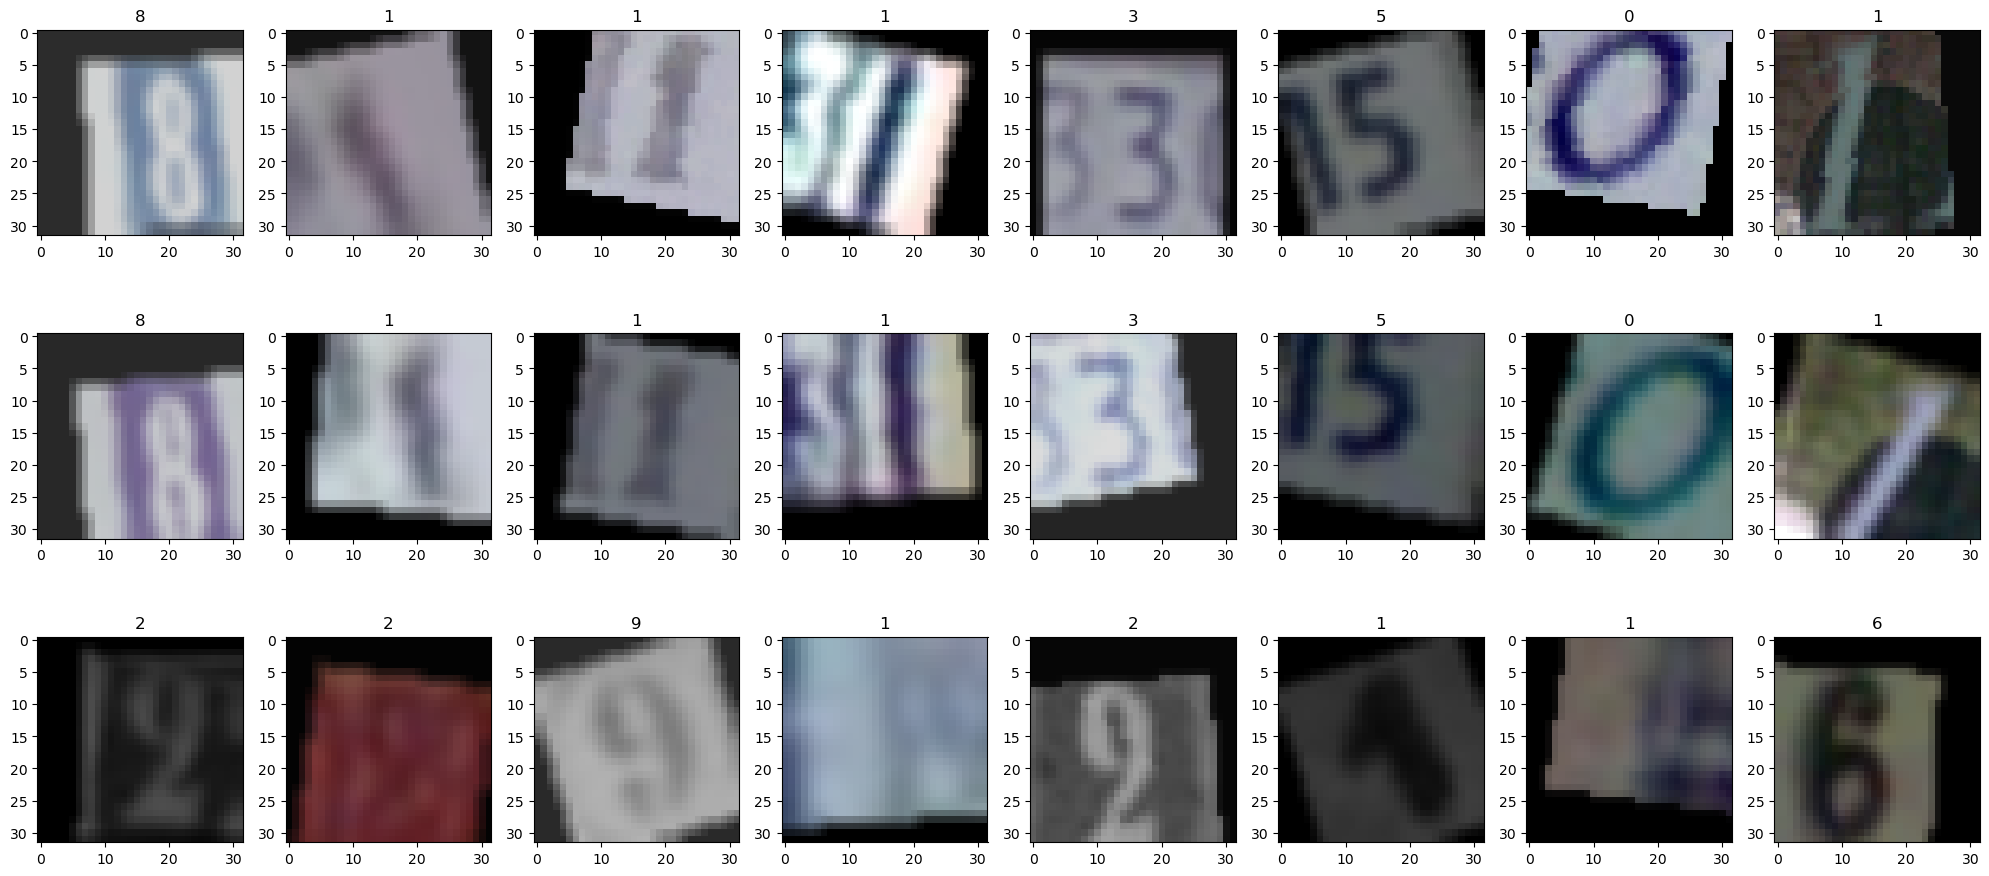

In [17]:
aug_imgs = x_i, xhat_i, x_j
labels = [y_i, y_i, y_j]
plot_slc_imgs(aug_imgs, labels, mean, std)

/tmp/ipykernel_89844/482099675.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


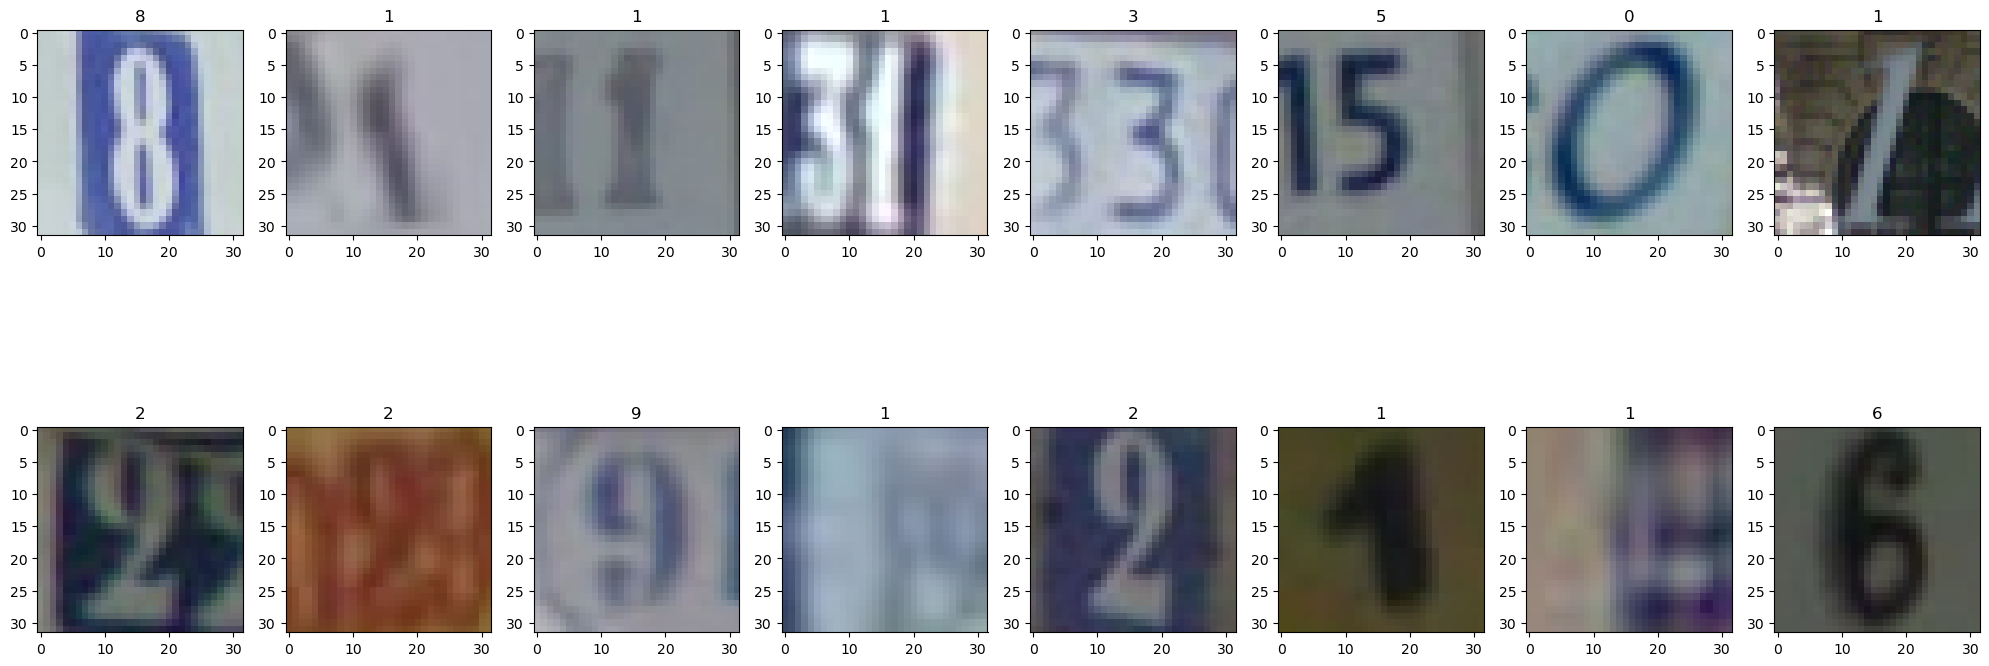

In [18]:
orig_imgs = x_i_orig, x_j_orig
labels = [y_i, y_j]
plot_slc_imgs(orig_imgs, labels, mean, std)

In [19]:
datasetname = "celeba"
traindataset, valdataset, testdataset, mean, std, num_classes = load_imagedataset(datasetname, val_split=0.1)

imgsize = 32
s = 0.5
gaus_blur = True
num_views = 1
p_flip = 0.5

dataloader = DataLoader(
    dataset=SCLDataset(
        traindataset,
        train_transform=SCLTrainTransform(
            imgsize=imgsize,
            mean=mean,
            std=std,
            s=s,
            gaus_blur=gaus_blur,
            num_views=num_views,
            p_flip=p_flip
        ),
        eval_transform=SCLEvalTransform(
            imgsize=imgsize,
            mean=mean,
            std=std,
            num_views=num_views,
        )
    ),
    batch_size=8,
    shuffle=False
)

x_i, xhat_i, x_j, y_i, y_j, x_i_orig, x_j_orig = next(iter(dataloader))

Files already downloaded and verified
Files already downloaded and verified


In [20]:
y_i

tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
         1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
         1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
         1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
         1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1],
        [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
         1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 

/tmp/ipykernel_89844/482099675.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


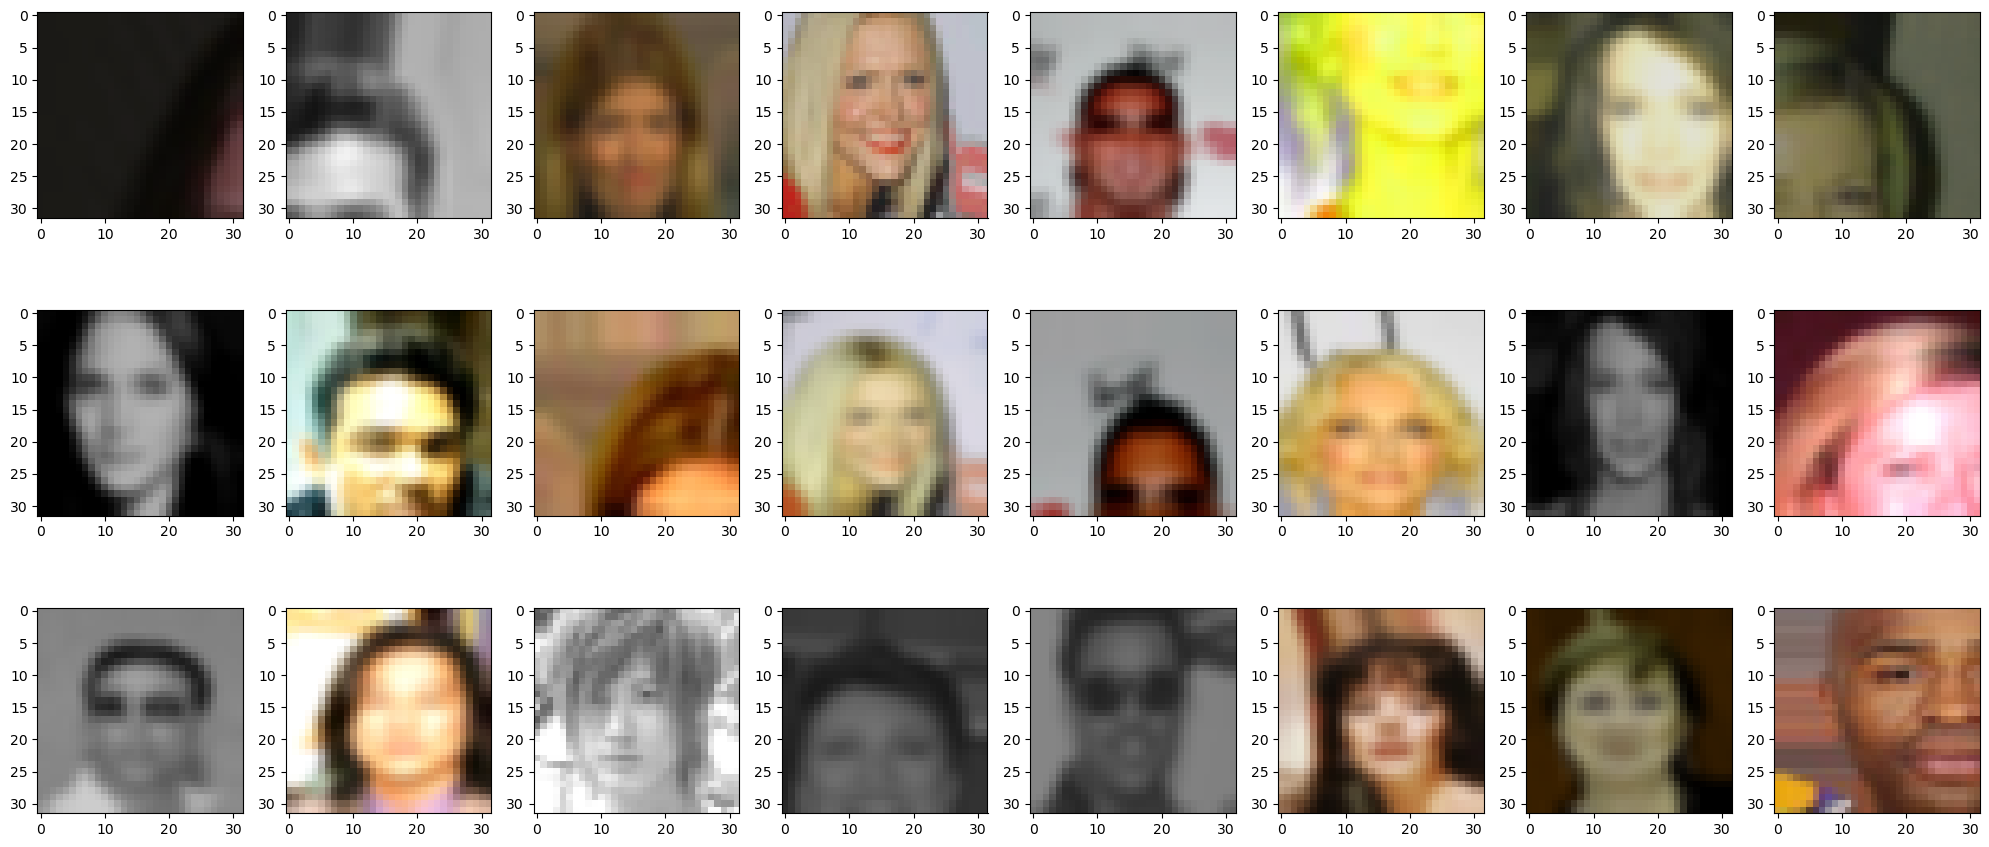

In [21]:
aug_imgs = x_i, xhat_i, x_j
labels = None # [y_i, y_i, y_j]
plot_slc_imgs(aug_imgs, labels, mean, std)

/tmp/ipykernel_89844/482099675.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


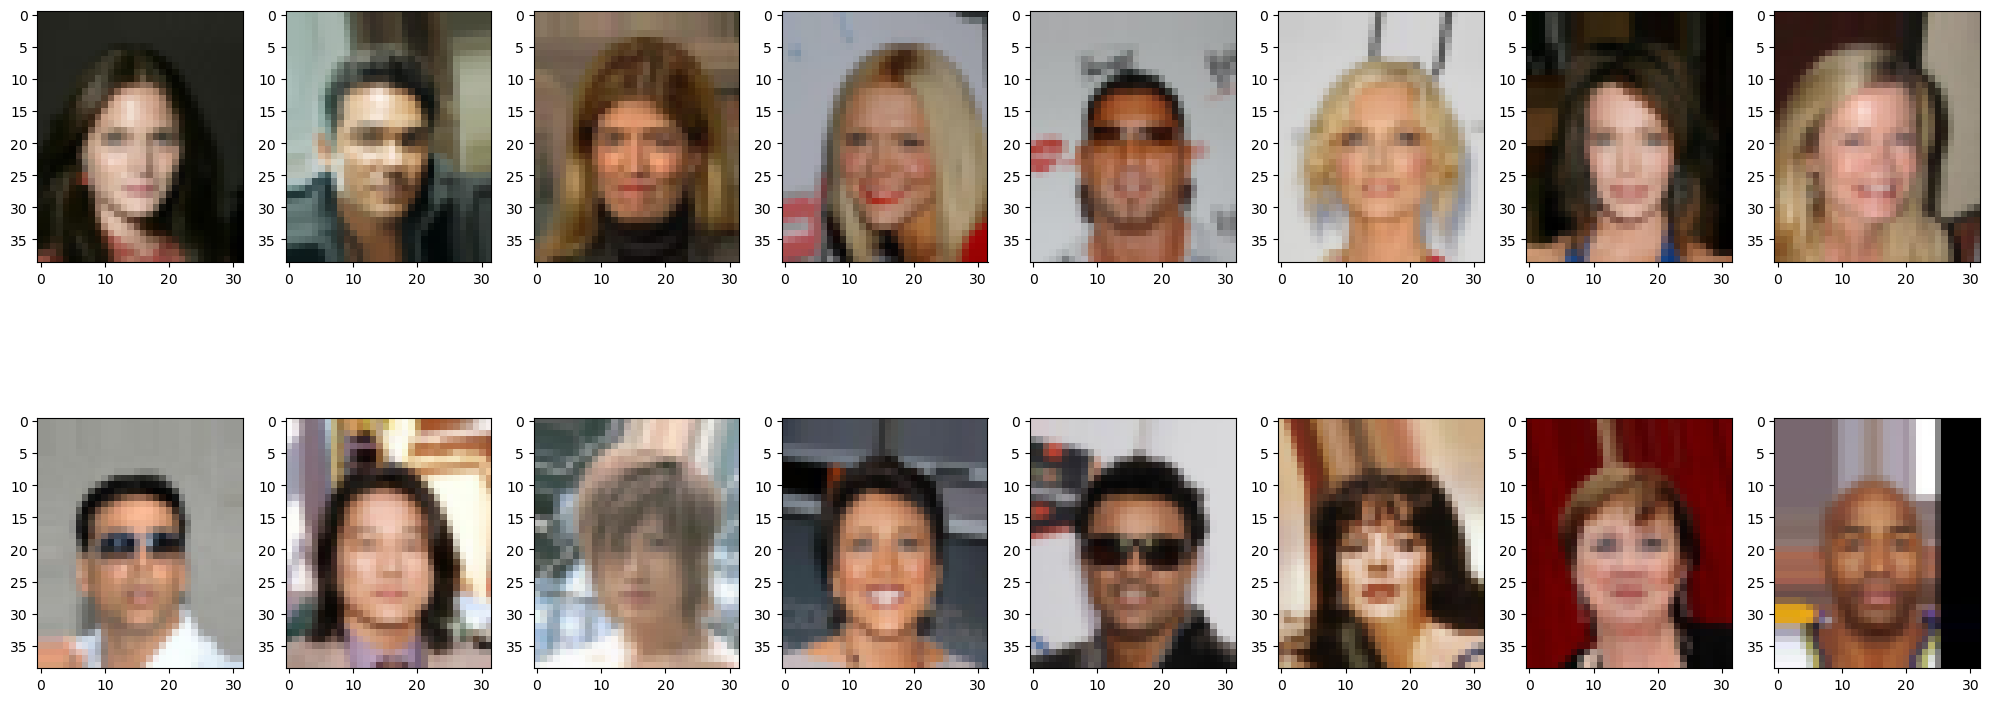

In [22]:
orig_imgs = x_i_orig, x_j_orig
labels = None # [y_i, y_j]
plot_slc_imgs(orig_imgs, labels, mean, std)

In [23]:
datasetname = "stl10"
traindataset, valdataset, testdataset, mean, std, num_classes = load_imagedataset(datasetname, val_split=0.1)

imgsize = 32
s = 0.5
gaus_blur = True
num_views = 1
p_flip = 0.0

dataloader = DataLoader(
    dataset=SCLDataset(
        traindataset,
        train_transform=SCLTrainTransform(
            imgsize=imgsize,
            mean=mean,
            std=std,
            s=s,
            gaus_blur=gaus_blur,
            num_views=num_views,
            p_flip=p_flip
        ),
        eval_transform=SCLEvalTransform(
            imgsize=imgsize,
            mean=mean,
            std=std,
            num_views=num_views,
        )
    ),
    batch_size=8,
    shuffle=False
)

x_i, xhat_i, x_j, y_i, y_j, x_i_orig, x_j_orig = next(iter(dataloader))

Files already downloaded and verified
Files already downloaded and verified


In [24]:
y_j

tensor([-1, -1, -1,  7, -1, -1, -1, -1])

/tmp/ipykernel_89844/482099675.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


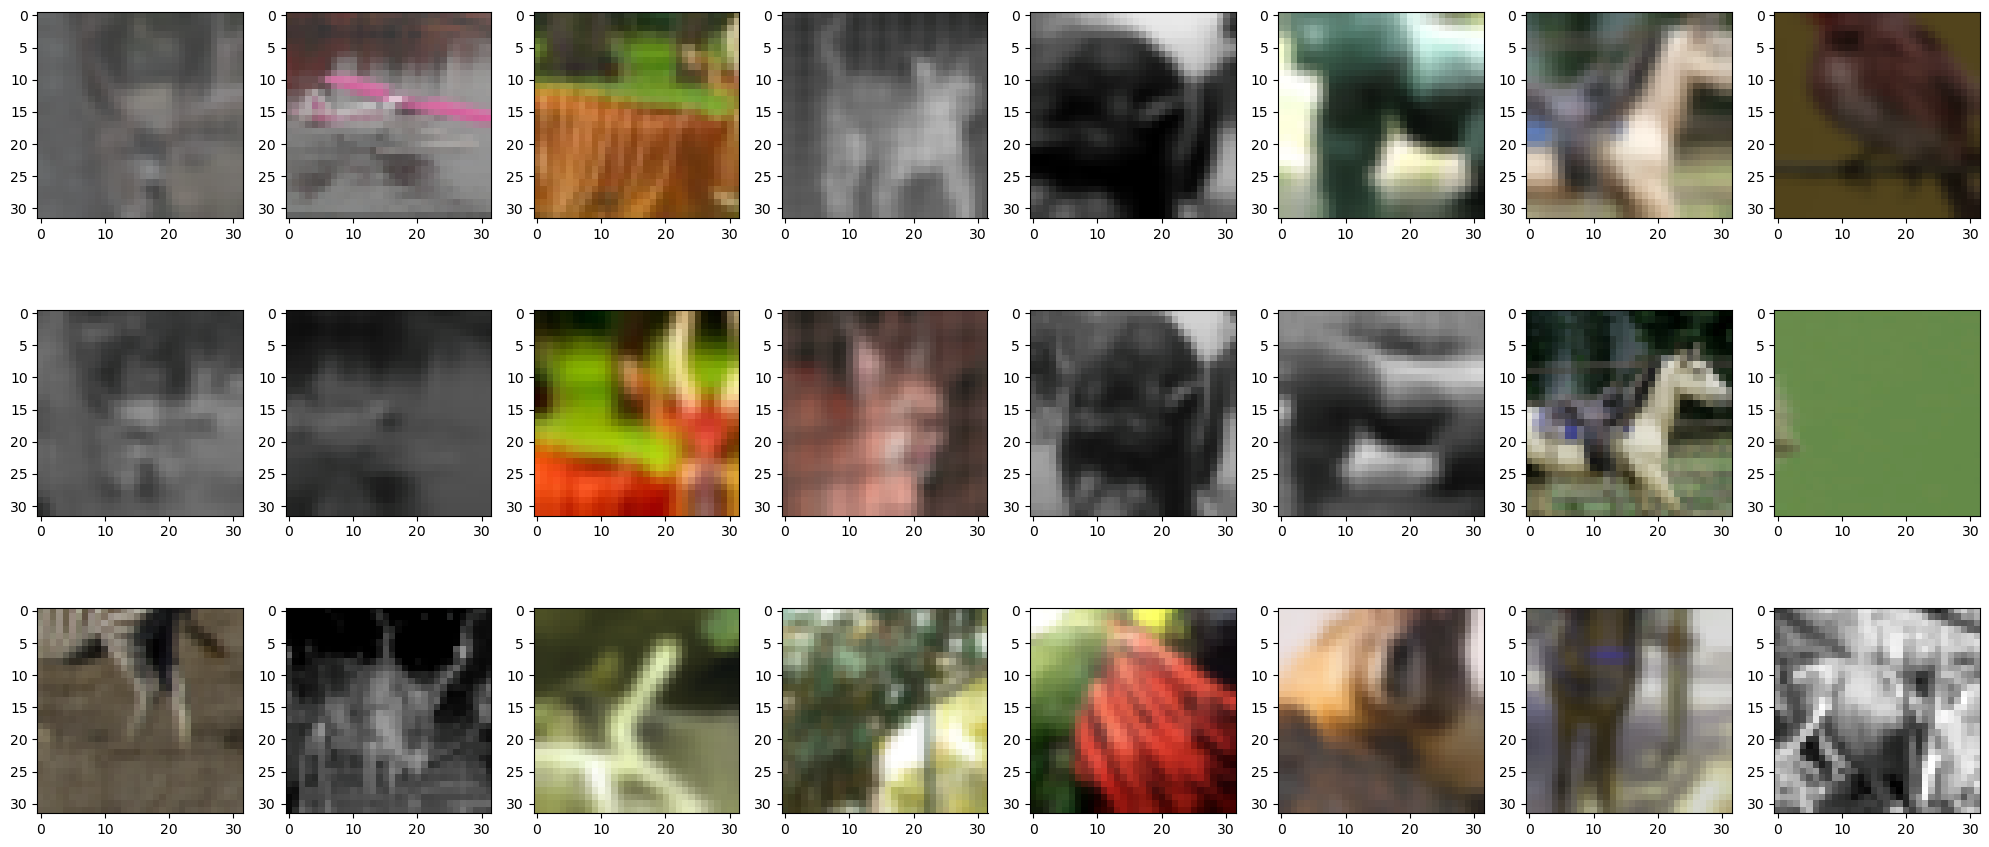

In [25]:
aug_imgs = x_i, xhat_i, x_j
labels = None # [y_i, y_i, y_j]
plot_slc_imgs(aug_imgs, labels, mean, std)

/tmp/ipykernel_89844/482099675.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


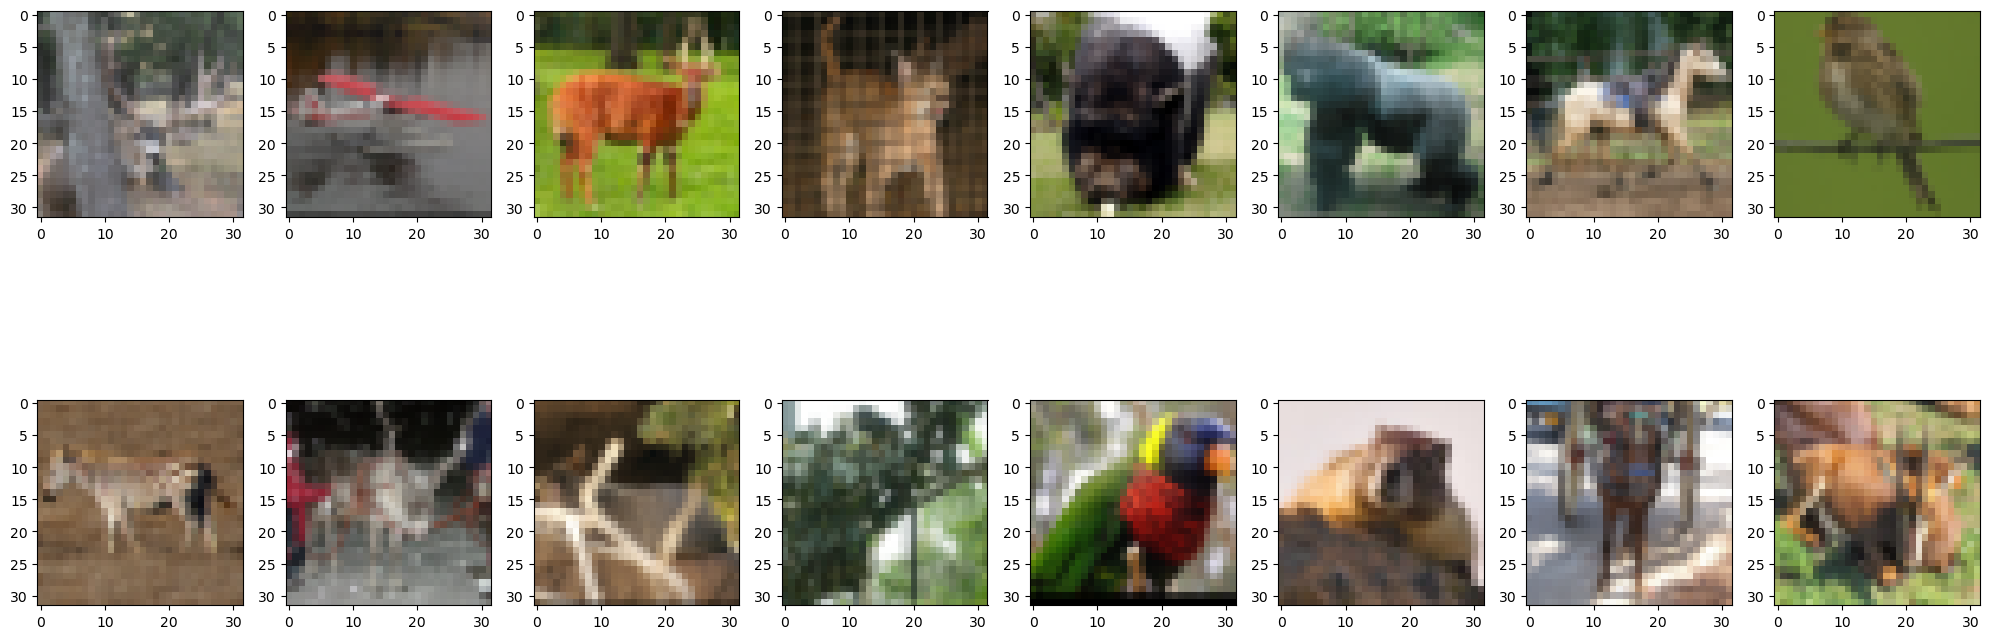

In [26]:
orig_imgs = x_i_orig, x_j_orig
labels = None # [y_i, y_j]
plot_slc_imgs(orig_imgs, labels, mean, std)